In [ ]:
# Assuming fundamental idea doesnt fail:

# Use correct COMSOL output, as in proposal , and reproduce sensitivity plot for proposal 

# add ABRA 10 cm, SHAFT, ADMX SLIC

In [1]:
import numpy as np
from astropy import units, constants
from astropy.units import def_unit

from scipy import stats
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('../rodd_style.mplstyle')

sys.path.append("/global/scratch/projects/pc_heptheory/jbenabou/comsol_2026/AxionLimits/")
from PlotFuncs import *


In [7]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html


from cycler import cycler

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = True 

In [3]:
# Mass-coupling relation
KSVZ = 1.92
DFSZ = 0.75

def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a


In [97]:
2*np.pi/ 5.07e6

1.2392870428362103e-06

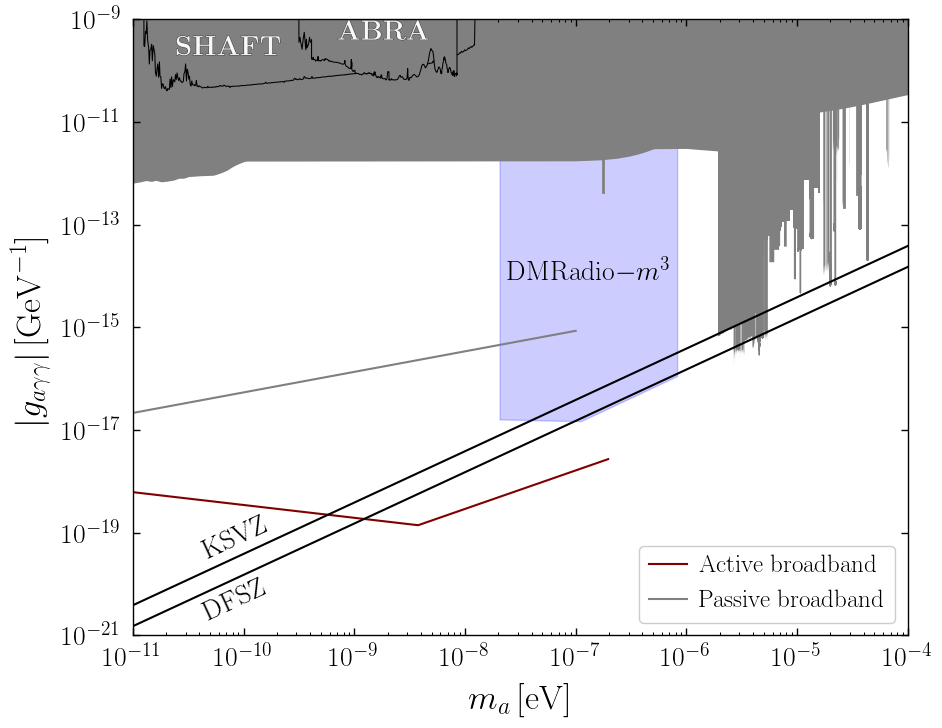

In [99]:
#(i) plot the m^3 sensitivity for broadband, as you have done before
# (ii) plot the sensitivity given in Eq. (15). It doesn't make sense to talk about scanning with ABBA---you just plot Eq. (15) of the notes I shared with you


voltage_to_eV = 3.30227
yr_to_s = 3.154e+7
H_to_inveV = 4.03278e+12 # !!! check this , probably 1/(2pi) off
Kelvin_to_eV = 8.617e-5
m_to_inv_eV = 5.07e6
Tesla_to_eV = 195
s_to_inveV = 1.519e15 
Hz_to_eV = 1/s_to_inveV 
cm_to_inv_eV = 1e-2 * m_to_inv_eV
Wb_to_eV = 5.02e15

# returns in units of 1/GeV
def g_agammagamma_limit(
    L_p,                 # pickup inductance (Henries)
    V_eff,               # effective volume (m^3 or whatever your convention is; must match the derivation)
    T,                   # temperature (Kelvin)
    Theta_limit,         # detection threshold parameter (dimensionless) in your formula
    B0,                  # magnetic field (Tesla, unless your derivation uses different units)
    m_a,                 # axion mass (same mass/energy units used in the derivation; often eV)
    t_exp,               # total exposure time (seconds)
    rho_DM,              # local DM density (same units as in derivation; often GeV/cm^3)
    Q,                   # resonator quality factor (dimensionless)
    Q_axion,             # axion "quality factor" ~ 1e6 (dimensionless)
    eta_A,
    Omega_star_Mhz, # see notes for definition of this
    omega_mqs_eV
):
    r"""
    Compute the approximate axion-photon coupling sensitivity:
        |g_{aγγ}^{limit}| ≈ (2/π)^(3/4) * √L_p/V_eff *
                           √T * Θ_limit^(1/4) / ( B0 * m_a^(1/4) * t_exp^(1/4) * √ρ_DM * √Q * Q_axion^(1/4) )

    IMPORTANT:
    ----------
    This function is purely algebraic. It does NOT do unit conversions.
    You must feed inputs in the SAME unit system used to derive the equation,
    otherwise the numeric value will be meaningless.

    Returns:
        g_limit (float)
    """

    L_p_eV = L_p * H_to_inveV
    T_eV = T* Kelvin_to_eV
    t_exp_eV = t_exp * s_to_inveV
    V_eff_eV = V_eff * m_to_inv_eV**3
    B0_eV = B0 * Tesla_to_eV
    rho_DM_eV = rho_DM* 1e9 /cm_to_inv_eV**3

    prefac = (2.0 / np.pi) ** (3.0 / 4.0)
    num = np.sqrt(L_p_eV) * np.sqrt(T_eV) * (Theta_limit ** 0.25)
    den = V_eff_eV * B0_eV * (m_a ** 0.25) * (t_exp_eV ** 0.25) * np.sqrt(rho_DM_eV) * np.sqrt(Q) * (Q_axion ** 0.25)

    res = prefac * (num / den) # 1/eV


    omega_star_eV = Omega_star_Mhz * 1e6 * Hz_to_eV
    k = 1 # !!! hardcoded
    omega_max_active =  k * np.sqrt(2*T_eV*omega_star_eV/Q) / np.sqrt(eta_A) #

    if m_a >=omega_max_active:
        res*=(m_a/omega_max_active)**(1)
    
    if m_a >=omega_mqs_eV:  # !!! careful factors of two pi , also do this more precisely
        res=np.inf

    res_GeV = res * 1e9

    return res_GeV

def gayy_limit_passive_BB(
    L_p,            # pickup inductance
    V_eff,          # effective volume
    m_a,            # axion mass
    S_Phi,          # flux noise spectral density (Wb^2 / Hz)
    Theta_limit,    # detection threshold parameter (dimensionless)
    B0,             # magnetic field
    t_exp,          # exposure time
    rho_DM,         # local dark matter density
    Q_axion,        # axion quality factor (~1e6)
    L_i,            # input inductance
):

    prefac = (512.0 / np.pi) ** 0.25

    L_p_eV = L_p * H_to_inveV
    t_exp_eV = t_exp * s_to_inveV
    V_eff_eV = V_eff * m_to_inv_eV**3
    B0_eV = B0 * Tesla_to_eV
    rho_DM_eV = rho_DM* 1e9 /cm_to_inv_eV**3
    L_i_eV = L_i * H_to_inveV
    S_Phi_eV = S_Phi *  Wb_to_eV**2 * s_to_inveV # Wb


    numerator = (
        np.sqrt(L_p_eV)
        * (m_a ** 0.25)
        * np.sqrt(S_Phi_eV)
        * (Theta_limit ** 0.25)
    )

    denominator = (
        V_eff_eV
        * B0_eV
        * (t_exp_eV ** 0.25)
        * np.sqrt(rho_DM_eV)
        * (Q_axion ** 0.25)
        * np.sqrt(L_i_eV)
    )

    res_eV = prefac * numerator / denominator
    
    res_GeV = res_eV * 1e9

    return res_GeV
    

# Replace these with your actual experiment parameters, in the SAME units used in your derivation.
L_p = 1e-6          # H # 
V_eff = 1         # m^3
T = 20e-3             # K
Theta_limit = 2.71   # dimensionless
B0 = 10.0           # T
m_a = 1e-6          # eV (example)
t_exp = yr_to_s         # s
rho_DM = 0.45        # GeV/cm^3 (example)
Q = 1e5             # dimensionless
Q_axion = 1e6       # dimensionless


plt.figure(figsize=(10,8))

#######################################
# ACTIVE

eta_A = 1
Omega_star_Mhz = 2*np.pi*100 # Mhz

r_typical = 1 # m 
omega_mqs_cutoff_eV = 1/ (r_typical * m_to_inv_eV) # careful factors of 2pi!!!

ma_arr_ABBA = np.geomspace(1e-12,1e-4,1000)
gayy_arr = np.array([g_agammagamma_limit(L_p, V_eff, T, Theta_limit, B0, ma, t_exp, rho_DM, Q, Q_axion, eta_A, Omega_star_Mhz, omega_mqs_cutoff_eV) for ma in ma_arr_ABBA])
plt.plot(ma_arr_ABBA, gayy_arr,color="maroon",label="Active broadband")

#######################################
# PASSIVE

Phi0 = 2.1e-15 # Wb
sqrt_S_Phi =  1e-6 *Phi0 # Wb/sqrt(Hz)        # flux noise spectral density (Phi^2 / Hz)
S_Phi = sqrt_S_Phi**2
L_i = 1e-9  # input inductance (H)


ma_arr = np.geomspace(1e-12,1e-7,1000)
gayy_arr_passive = np.array([gayy_limit_passive_BB(L_p, V_eff, ma, S_Phi, Theta_limit, B0, t_exp, rho_DM, Q_axion, L_i) for ma in ma_arr_ABBA])
plt.plot(ma_arr, gayy_arr_passive,color="grey",label="Passive broadband")



#######################################
# DM-RADIO RESONANT

DMRadio_m3_res_proj = np.loadtxt("DMRadio_m3_5yr_2204.13781.csv",delimiter=",")

plt.fill_between(DMRadio_m3_res_proj[:,0],DMRadio_m3_res_proj[:,1],1e40*DMRadio_m3_res_proj[:,1],color="blue",alpha=0.2,zorder=-100)
plt.text(2.4e-8, 8e-15, r"$\mathrm{DMRadio-}m^3$", fontsize=fs)

#######################################
KSVZ = 1.92
DFSZ = 0.75

ma_arr = np.geomspace(1e-13,1e-3,1000)

# ma in eV , gayy in 1/ GeV
def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a
    
gayy_KSVZ  = np.array([g_x(KSVZ,ma) for ma in ma_arr])
gayy_DFSZ  = np.array([g_x(DFSZ,ma) for ma in ma_arr])

plt.plot(ma_arr, gayy_KSVZ,color="k")
plt.plot(ma_arr, gayy_DFSZ,color="k")

#xtext, ytext, r = 3e-7, 1e-17, 20
xtext, ytext, r = 4e-11, 2e-21, 15

plt.text(xtext, r*ytext, "KSVZ", fontsize=fs, rotation=25)
plt.text(xtext, ytext, "DFSZ", fontsize=fs, rotation=25)

#######################################
plt.xlabel(r"$m_a \, [\mathrm{eV}]$")
plt.ylabel(r"$|g_{a\gamma\gamma}| \, [\mathrm{GeV}^{-1}]$")

plt.xlim([1e-12,1e-4])
plt.xscale("log")
plt.yscale("log")
plt.legend()

#######################

AxionPhoton.QCDAxion(ax,C_center=abs(5/3-1.92)*(44/3-1.92)/2,C_width=0.7,vmax=1.1,KSVZ_on=False,DFSZ_on=False)

text_on=False

# colors
Astro = 'grey' #'seagreen'
AstroDM = [0.7,0.7,0.7]
ExperimentDM = 'grey' #'royalblue'
ExperimentLab = 'grey' #'#a83246'
ExperimentStellar = 'grey'
Collider = 'grey' #'#a83246'

AxionPhoton.ALPS(ax,projection=False,text_on=text_on,col=ExperimentLab,lw=1.5)
AxionPhoton.PVLAS(ax,text_on=text_on,col=ExperimentLab,lw=1.5)
AxionPhoton.OSQAR(ax,text_on=text_on,col=ExperimentLab,lw=1.6)
        
#AxionPhoton.Helioscopes(ax,text_on=False,col=ExperimentStellar)
AxionPhoton.HaloscopesUniform(ax,text_on=False,col=ExperimentDM)#,edgecolor="none")

AxionPhoton.Mrk421(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.NGC1275(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.HESS(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.StarClusters(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.SN1987A_gamma(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.Fermi(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.FermiQuasars(ax,text_on=False,col=Astro,lw=0.5,edgealpha=0)
AxionPhoton.MWDPolarisation(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.MWDXrays(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.PulsarPolarCap(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.NuSTAR_Sun(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.HAWC(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.MAGIC(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.M82(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)
AxionPhoton.Planck_unWISE(ax,col=Astro,text_on=False,lw=0.5,edgealpha=0)

fs = 20
#plt.text(2.7e-10,0.8e-12,r'{\bf Astrophysics}',color=Astro,rotation=0,path_effects=line_background(0.5,'k'),fontsize=fs)
plt.text(2.4e-11,2e-10,r'{\bf SHAFT}',rotation=0,color='w',alpha=0.8,path_effects=line_background(0.5,'k'),fontsize=fs)
plt.text(0.7e-9,4e-10,r'{\bf ABRA}',rotation=0,color='w',alpha=0.8,path_effects=line_background(0.5,'k'),fontsize=fs)
#plt.text(0.7e-6,0.03e-13,r'{\bf Haloscopes}',rotation=90,color=ExperimentDM,path_effects=line_background(0.5,'k'),fontsize=fs)
#plt.text(0.2e-8,0.7e-18,r'{\bf QCD axion}',fontsize=30,color='goldenrod',rotation=31,alpha=1,path_effects=line_background(0.75,'k'))
###########################################################

plt.ylim([1e-21,1e-9])
plt.xlim([1e-11,1e-4])


plt.savefig("money_plot.pdf", bbox_inches="tight")


# Let's define our units

- Impedances – $\Omega$  
- Inductance – H
- Voltage - V
- Frequency – MHz  
- Temperature – mK
- Magnetic Field - Tesla

In [4]:
planck_h = constants.h.to(units.eV/units.MHz).value
boltzmann_k = constants.k_B.to(units.eV/units.mK).value

# Some useful unit conversions from GUTCalc
voltage_to_eV = 3.30227
henry_to_inveV = 4.03278e+12

# A/m^2 * GeV / T
external_current_units = 10.6049

In [5]:
rescale_factor = 1

In [6]:
1/external_current_units

0.09429603296589312

In [7]:
# Loading the data
# voltage_data = np.loadtxt('../Shielded_Solenoid/Port_Voltage_5_50.txt', skiprows = 5).T
# source_impedance_data = np.loadtxt('../Shielded_Solenoid/Source_Impedance_5_50.txt', skiprows = 5).T




# source_impedance_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_impedance.npy')
# voltage_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_voltage.npy')


res_folder='Shielded_Solenoid/josh_independent_check_shreya_geometry'
source_impedance_data = np.load(res_folder+'/source_impedance.npy')
voltage_data = np.load(res_folder+'/source_voltage.npy')

frequencies = 1e3*source_impedance_data[0] / rescale_factor
source_reactance = source_impedance_data[2] * rescale_factor# Sim was lossless.
source_voltage = rescale_factor**2 * np.abs(voltage_data[1]+1j*voltage_data[2]) # Don't care about phase



locs =np.where(frequencies<=np.inf)
frequencies = frequencies[locs]
source_reactance = source_reactance[locs]
source_voltage = source_voltage[locs]

# Defining the splines
get_source_voltage = CubicSpline(frequencies, source_voltage)
get_source_reactance = CubicSpline(frequencies, source_reactance)
get_source_reactance_derivative = get_source_reactance.derivative()

In [8]:
def get_Leff(freq):
    """
    Compute the effective inductance L_eff at a given frequency.
    This implements Eq. (6) from arXiv:2302.14084:
        L_eff(f) = [Z_s(f) + f * dZ_s/df] / (4π f)
    """
    
    # Compute numerator: freq * dZs/df + Zs, all in Ohms
    numerator = freq * get_source_reactance_derivative(freq)+ get_source_reactance(freq)
    denominator = 4 * np.pi * (1e6*freq)

    return (numerator / denominator)

(1e-18, 1e-10)

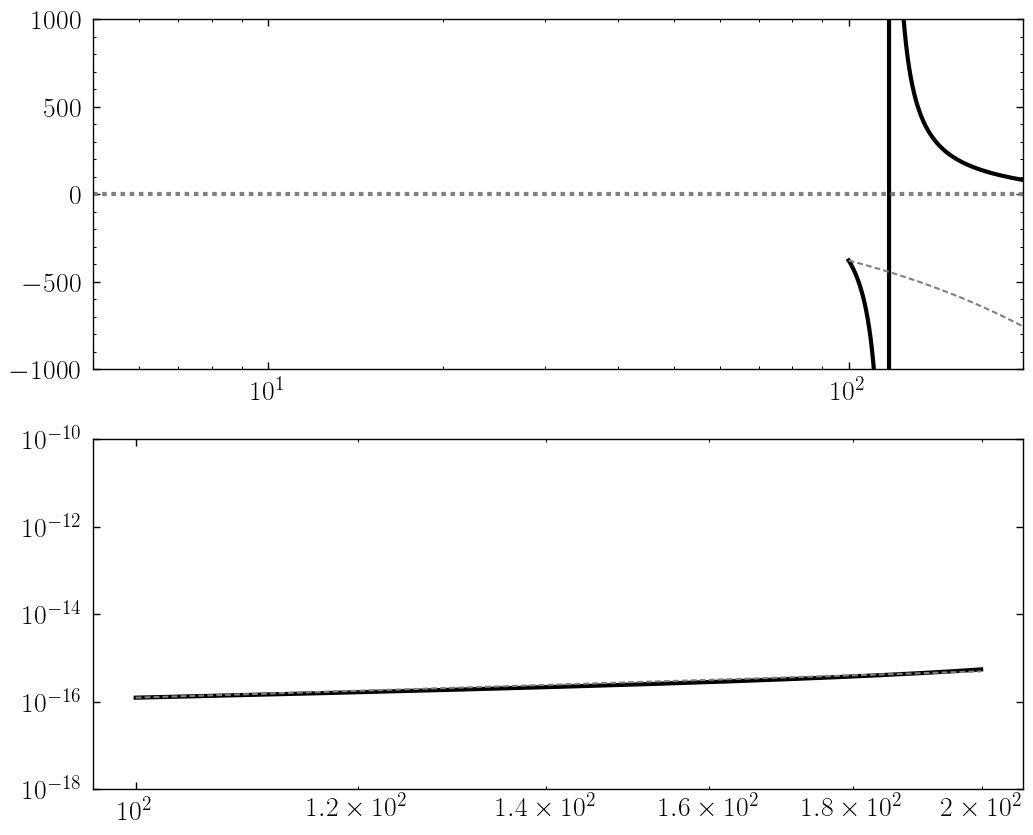

In [9]:
fig, axs = plt.subplots(nrows = 2, figsize = (12,10))

axs[0].plot(frequencies,  source_reactance,color = 'black', lw= 3)
axs[0].plot(frequencies,  source_reactance[0] * frequencies/ frequencies[0],color = 'grey', ls='--')
axs[0].set_ylim(-1e3, 1e3)
axs[0].set_xlim(5,200)

dfsz_coupling = g_x(DFSZ, 2*np.pi * 6.58212e-10 * frequencies)
axs[1].plot(frequencies, 10*source_voltage  * dfsz_coupling, color = 'black', lw =3)
axs[1].plot(frequencies, 10*source_voltage[0] * (frequencies/frequencies[0])*dfsz_coupling, color = 'grey', ls = '--')
axs[1].set_yscale('log')
axs[0].set_xlim(5,200)

axs[0].axhline(0, color= 'grey', lw = 3, ls = ':')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_ylim(1e-18,1e-10)

# Scan Rate Calculation

In [10]:
def get_GBar(nu_r, T, eta_A=10):
    
    # --- Compute thermal photon occupation number n_T ---
    exponent = (planck_h * nu_r) / (boltzmann_k * T)
    n_T = 1 / (np.exp(exponent) - 1)

    # --- Compute alpha_bar (Eq. 13) ---
    two_nT_plus_1 = 2 * n_T + 1
    alpha_bar = (2 * eta_A**2) / (two_nT_plus_1 + np.sqrt(two_nT_plus_1**2 + 8 * eta_A**2))

    # --- Compute Ḡ (Eq. 12) ---
    denom = (alpha_bar**2 + 2 * two_nT_plus_1 * alpha_bar + eta_A**2)**(3 / 2)
    GBar = alpha_bar / denom

    return GBar

In [11]:
# Defining our 95% exclusion threshold
snr_target = stats.chi2.ppf(.9, df = 1)**.5

def dnu_dt(nu_r, Q=2e5, T=10, C_ag = KSVZ, B = 5):

    ma_nat = constants.h.to('eV/MHz').value * nu_r # [eV]
    prefactor = 6.4e5*np.pi / snr_target**2 / 16 / ma_nat**4 # [1/eV^4]

    GBar = get_GBar(nu_r, T) # unitless
    Leff = get_Leff(nu_r)*henry_to_inveV # [1/eV]

    # The voltage was computed using an external current density with |J| = 1 A / m^2 so now
    # now we need to convert this to the appropriate current density for our axion scenario
    g_agg = g_x(C_ag, ma_nat) # GeV^(-1)
    voltage_rescaling = external_current_units * g_agg * B # A / m^2
    V = voltage_rescaling * get_source_voltage(nu_r) * voltage_to_eV # [eV]
    print(nu_r[0],prefactor[0], V[0], Leff[0], Q, GBar[0])
    
    # Now calculate scan rate
    scan_rate = prefactor * V**4 * Q * GBar  / Leff**2 # [eV^2]
    scan_rate /= constants.h.to('eV/MHz').value # [eV-Hz]
    scan_rate /= constants.h.to(units.eV * units.yr).value    
    
    return scan_rate

100.0 1.5877159498947013e+30 3.913528259341743e-15 -8706509.072739722 10000.0 0.002347236970104411
100.0 1.5877159498947013e+30 1.0018632343914861e-12 -8706509.072739722 10000.0 0.002347236970104411


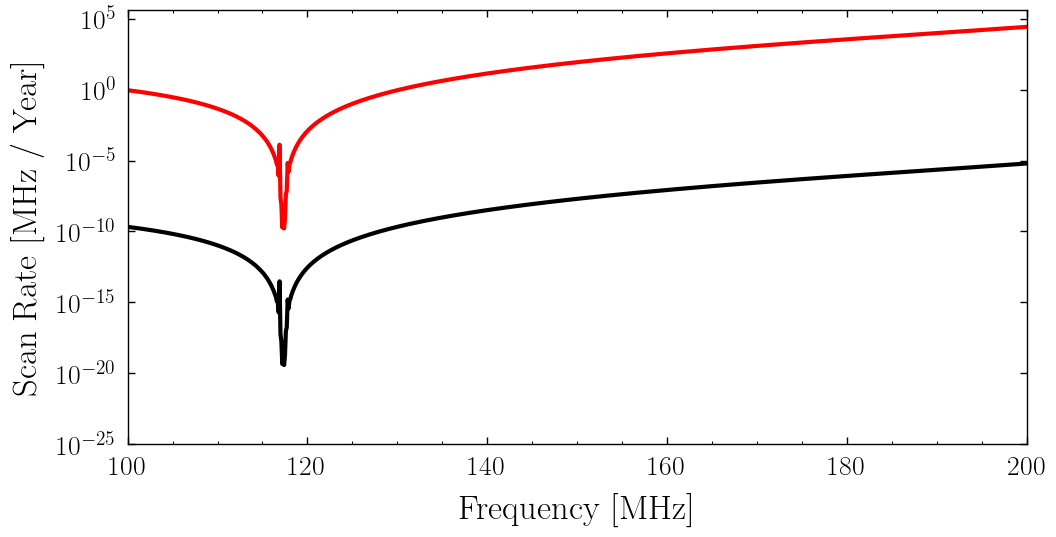

In [12]:
fig, axs = plt.subplots(figsize = (10, 5))

#match_x= frequencies[0]
#match_y = np.interp(match_x,frequencies, dnu_dt(frequencies, Q = 1e6, B = 15, C_ag = DFSZ))


plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = DFSZ), color = 'black', lw = 3)
plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = 100*KSVZ), color = 'red', lw = 3)
#plt.plot(frequencies, dnu_dt(frequencies, Q = 1e6, B = 10, C_ag = KSVZ), color = 'black', lw = 3,ls = '--')
#plt.xlim(frequencies[0], frequencies[-1])
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout()
#plt.axvspan(10, 58)
plt.ylim(1e-25, None)
plt.xlim(100,200)

#plt.ylim(1e-4, 1e2)
plt.xlabel('Frequency [MHz]')
plt.ylabel("Scan Rate [MHz / Year]")
plt.savefig('./WithWrongScaling.png')